In [ ]:
#!pip install numba

In [1]:
#### Implementation of ANN with SGD and Backprop
#### original OOP implementation can be found at: https://medium.com/binaryandmore/beginners-guide-to-deriving-and-implementing-backpropagation-e3c1a5a1e536
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
## layer:
## take input X: (Nx1)
## multiply by weights W: (h1xN)
## add bias b: (h1x1)
def layer(X, W, b): return np.dot(W, X) + b

In [3]:
## lets take the activation as sigmoid (element-wise)
def sigmoid(x): return 1 / (1 + np.exp(-x))

In [4]:
## lets define the derivative of the sigmoid
def sigmoid_prime(x): return sigmoid(x)*(1.0 - sigmoid(x))

In [5]:
## define the mse cost per sample
def mse(y_pred, y_true): return (1 / 2) * np.square(y_pred - y_true)

In [6]:
## derivative of mse
def mse_prime(y_pred, y_true): return (y_pred - y_true)

In [7]:
## NN parameters
N = 50
num_nes = [N, 40, 30, 20, 10]
num_layers = len(num_nes) - 1
learning_rate = 0.01
num_epochs = 1000
num_data_samples = 100

## dict to hold neuron input-output pairs
layer_in_out_dict = dict()
## dict to hold the cost derivatives w.r.t to the params
layer_derivative_dict = dict()

In [8]:
## the dict to hold the layer weights and biases
weight_dict = {'w'+str(i): np.random.normal(size=(num_nes[i+1], num_nes[i])) for i in range(num_layers)}
bias_dict = {'b'+str(i): np.random.normal(size=(num_nes[i+1], 1)) for i in range(num_layers)}

In [9]:
def NN(inputs):
    a = inputs
    layer_in_out_dict['a0'] = a
    ## forward pass
    for i in range(num_layers):
        #print(i)
        z = layer(a, weight_dict['w'+str(i)], bias_dict['b'+str(i)])
        a = sigmoid(z)
        layer_in_out_dict['z'+str(i)] = z
        layer_in_out_dict['a'+str(i+1)] = a
    out = a
    return out

In [10]:
## Test the NN with a dummy forward pass
inp = np.random.uniform(0, 1, size=(N,1)) * 255.0
out_true = np.random.uniform(0, 1, size=(num_nes[-1], 1))
out = NN(inp)
error = mse(out, out_true)
print(np.mean(error))

0.10535012367841672


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [11]:
## Function to perform model prediction
def predict(inputs): return NN(inputs)

In [12]:
def compute_grads(inputs, targets):
    ## perform a forward pass (prediction)
    out = predict(inputs)
    ## Compute dC/dzL, dC/dwL and dC/dbL
    ## first dC/dzL = (a - y) * a * (1 - a)
    layer_derivative_dict['dz'+str(num_layers-1)] = mse_prime(out, targets) * out * (1 - out)
    ## second compute the dC/dwL = dC/dzL * dzL/dwL
    #print(layer_derivative_dict['dz'+str(num_layers-1)].shape)
    #print(layer_in_out_dict['a'+str(num_layers-1)].shape)
    layer_derivative_dict['dw'+str(num_layers-1)] = np.dot(layer_derivative_dict['dz'+str(num_layers-1)], \
                                                    np.transpose(layer_in_out_dict['a'+str(num_layers-1)]))
    ## third calculate the dC/dbL = dC/dzL * dzL/dbL
    layer_derivative_dict['db'+str(num_layers-1)] = layer_derivative_dict['dz'+str(num_layers-1)] * 1
    
    ## Now since we have the derivatives at the output layer, we can calculate the derivatives for the rest of the 
    ## layers
    for i in reversed(range(num_layers-1)):
        #print(i)
        ## first compute dC/dzl = [w(l+1)*dC/dz(l+1)]*sigmoid_prime(zl)
        layer_derivative_dict['dz'+str(i)] = np.dot(
                                                np.transpose(weight_dict['w'+str(i+1)]), layer_derivative_dict['dz'+str(i+1)]) \
                                                * sigmoid_prime(layer_in_out_dict['z'+str(i)])
        ## second compute dC/dwl = dC/dzl * dzl/dwl
        layer_derivative_dict['dw'+str(i)] = layer_derivative_dict['dz'+str(i)] * \
                                                    np.transpose(layer_in_out_dict['a'+str(i)])
        
        ## third compute dC/dbl = dC/dzl * dzl/dbl
        layer_derivative_dict['db'+str(i)] = layer_derivative_dict['dz'+str(i)] * 1

In [13]:
## test the gradient computation 
compute_grads(inp, out_true)
#print(layer_derivative_dict)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [14]:
def update_param():
    for i in range(num_layers):
        weight_dict['w'+str(i)] = weight_dict['w'+str(i)] - learning_rate * layer_derivative_dict['dw'+str(i)]
        bias_dict['b'+str(i)] = bias_dict['b'+str(i)] - learning_rate * layer_derivative_dict['db'+str(i)]

In [15]:
## test param update function
update_param()

In [16]:
## make a dummy training dataset
inp_data = np.random.normal(size=(num_data_samples, num_nes[0]))
out_true_data = np.random.normal(size=(num_data_samples, num_nes[-1]))
#print(training_data)

In [17]:
mean_epoch_error_list = list()
for e in range(num_epochs):
    epoch_loss_list = list()
    for i in range(num_data_samples):
        inp = np.expand_dims(inp_data[i], 1)
        out_true = np.expand_dims(out_true_data[i], 1)
        #print(inp.shape)
        compute_grads(inp, out_true)
        update_param()
        out = predict(inp)
        error = np.mean(mse(out, out_true))
        epoch_loss_list.append(error)
    mean_epoch_error = np.mean(np.array(epoch_loss_list))
    mean_epoch_error_list.append(mean_epoch_error)
    print("Epoch loss: {}".format(mean_epoch_error))

Epoch loss: 0.63545521158502
Epoch loss: 0.5707487719625611
Epoch loss: 0.5418010912897967
Epoch loss: 0.5322537210166876
Epoch loss: 0.5252352458540078
Epoch loss: 0.5120322529673478
Epoch loss: 0.4903820431959221
Epoch loss: 0.4784175246646727
Epoch loss: 0.47440973870580033
Epoch loss: 0.4724903999669767
Epoch loss: 0.471236798242433
Epoch loss: 0.4702618050646005
Epoch loss: 0.4694270392897862
Epoch loss: 0.468673124718063
Epoch loss: 0.46797096258656745
Epoch loss: 0.4673047877872746
Epoch loss: 0.46666535397636627
Epoch loss: 0.4660468500120445
Epoch loss: 0.46544537035478695
Epoch loss: 0.4648581041659831
Epoch loss: 0.46428288782051724
Epoch loss: 0.4637179564683463
Epoch loss: 0.4631618128409891
Epoch loss: 0.46261316854234613
Epoch loss: 0.46207092939274796
Epoch loss: 0.4615342035844535
Epoch loss: 0.4610023154966584
Epoch loss: 0.46047481190602624
Epoch loss: 0.45995145193687825
Epoch loss: 0.4594321773407697
Epoch loss: 0.45891706508076885
Epoch loss: 0.4584062688978115
Ep

Epoch loss: 0.36142283324084673
Epoch loss: 0.3611783330114824
Epoch loss: 0.36093323896772084
Epoch loss: 0.36068742252298525
Epoch loss: 0.3604407391369168
Epoch loss: 0.3601930221956286
Epoch loss: 0.359944077554985
Epoch loss: 0.35969368021678066
Epoch loss: 0.35944157512773356
Epoch loss: 0.3591874846809386
Epoch loss: 0.35893112610168243
Epoch loss: 0.35867224227967415
Epoch loss: 0.3584106491794974
Epoch loss: 0.35814630062576436
Epoch loss: 0.3578793655625136
Epoch loss: 0.3576103029954008
Epoch loss: 0.3573399078281983
Epoch loss: 0.35706929432005646
Epoch loss: 0.3567997947070144
Epoch loss: 0.3565327841262483
Epoch loss: 0.3562694841377299
Epoch loss: 0.35601081349709657
Epoch loss: 0.3557573287226623
Epoch loss: 0.3555092496583736
Epoch loss: 0.3552665340936956
Epoch loss: 0.35502896417099244
Epoch loss: 0.35479622207821726
Epoch loss: 0.3545679469185675
Epoch loss: 0.3543437729094424
Epoch loss: 0.35412335241092563
Epoch loss: 0.3539063679864618
Epoch loss: 0.3536925372103

Epoch loss: 0.3263866585644946
Epoch loss: 0.3263335707146115
Epoch loss: 0.32628069978279867
Epoch loss: 0.3262280433708684
Epoch loss: 0.326175599162884
Epoch loss: 0.32612336492192556
Epoch loss: 0.32607133848696407
Epoch loss: 0.32601951776984595
Epoch loss: 0.3259679007523942
Epoch loss: 0.32591648548362956
Epoch loss: 0.3258652700771149
Epoch loss: 0.32581425270842546
Epoch loss: 0.3257634316127478
Epoch loss: 0.3257128050826067
Epoch loss: 0.32566237146572036
Epoch loss: 0.3256121291629819
Epoch loss: 0.3255620766265636
Epoch loss: 0.32551221235813954
Epoch loss: 0.3254625349072189
Epoch loss: 0.32541304286958417
Epoch loss: 0.32536373488582243
Epoch loss: 0.32531460963994
Epoch loss: 0.32526566585804695
Epoch loss: 0.3252169023070995
Epoch loss: 0.3251683177936824
Epoch loss: 0.32511991116281747
Epoch loss: 0.32507168129678105
Epoch loss: 0.32502362711391153
Epoch loss: 0.32497574756739006
Epoch loss: 0.3249280416439764
Epoch loss: 0.3248805083626803
Epoch loss: 0.3248331467733

Epoch loss: 0.31623514801915253
Epoch loss: 0.31621032942426697
Epoch loss: 0.3161856525179569
Epoch loss: 0.3161611148310304
Epoch loss: 0.3161367138668438
Epoch loss: 0.31611244711645364
Epoch loss: 0.31608831207175553
Epoch loss: 0.31606430623676735
Epoch loss: 0.31604042713722175
Epoch loss: 0.3160166723286266
Epoch loss: 0.3159930394029537
Epoch loss: 0.31596952599410333
Epoch loss: 0.31594612978228925
Epoch loss: 0.31592284849747204
Epoch loss: 0.3158996799219648
Epoch loss: 0.3158766218923198
Epoch loss: 0.3158536723005955
Epoch loss: 0.3158308290950936
Epoch loss: 0.31580809028064466
Epoch loss: 0.31578545391851315
Epoch loss: 0.3157629181259832
Epoch loss: 0.3157404810756784
Epoch loss: 0.31571814099466344
Epoch loss: 0.31569589616336663
Epoch loss: 0.31567374491436007
Epoch loss: 0.31565168563102486
Epoch loss: 0.3156297167461288
Epoch loss: 0.3156078367403361
Epoch loss: 0.31558604414066915
Epoch loss: 0.3155643375189351
Epoch loss: 0.3155427154901317
Epoch loss: 0.315521176

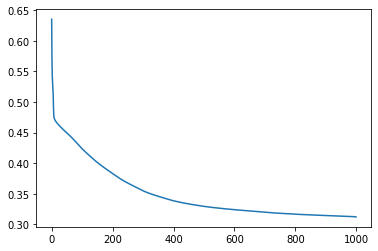

In [18]:
## Plot the model performance
plt.plot(np.arange(0, num_epochs, 1), mean_epoch_error_list)

In [19]:
print(np.max(layer_derivative_dict['dw3']))

0.026769107693524523


In [392]:
#### MNIST EXAMPLE ####

In [20]:
## load mnist data
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
#print(train_images.shape)
#print(train_labels.shape)

In [46]:
## make a mlp to process them
N = 784
num_nes = [N, 40, 30, 20, 10]
num_layers = len(num_nes) - 1
learning_rate = 0.01
num_epochs = 10
threshold = 0.5

In [47]:
## initialize the layer derivative and in out dicts
## dict to hold neuron input-output pairs
layer_in_out_dict = dict()
## dict to hold the cost derivatives w.r.t to the params
layer_derivative_dict = dict()
## Initialize the weights
## the dict to hold the layer weights and biases
weight_dict = {'w'+str(i): np.random.normal(size=(num_nes[i+1], num_nes[i])) for i in range(num_layers)}
bias_dict = {'b'+str(i): np.random.normal(size=(num_nes[i+1], 1)) for i in range(num_layers)}

In [48]:
def onehot(label):
    ## make an empty vector
    onehot_label = np.zeros((num_nes[-1], 1))
    onehot_label[label] = 1
    return onehot_label

In [49]:
def infer(inputs):
    pred_list = list()
    for i in range(inputs.shape[0]):
        inp = np.expand_dims(inputs[i].flatten(), 1)
        #print(inp.shape)
        pred = predict(inp)
        #print(pred.shape)
        pred_list.append(np.swapaxes(pred, 0, 1))
    #print(np.array(pred_list).shape)
    return np.squeeze(np.swapaxes(np.array(pred_list), 0, 1), 0)

In [50]:
def accuracy(preds, target, is_validation=False):
    ## threshold the predictions to 0,1
    #print(targets.shape)
    #print(preds > 0.1)
    positive_preds = 0
    for i in range(preds.shape[1]):
        ## current pred boolean
        if is_validation:
            pred = preds[i][target[i]] > threshold
        else:
            pred = preds[target] > threshold
        if pred:
            positive_preds += 1
    return positive_preds / preds.shape[1]

In [51]:
mean_epoch_error_list = list()
mean_epoch_train_accuracy_list = list()
mean_epoch_test_accuracy_list = list()
for e in range(num_epochs):
    epoch_loss_list = list()
    train_epoch_accuracy_list = list()
    for i in range(train_images.shape[0]):
        inp = np.expand_dims(train_images[i].flatten(), 1)
        #print(inp.shape)
        out_true = onehot(train_labels[i])
        #print(out_true.shape)
        compute_grads(inp, out_true)
        update_param()
        out = predict(inp)
        error = np.mean(mse(out, out_true))
        epoch_loss_list.append(error)
        train_sample_accuracy = accuracy(out, train_labels[i])
        train_epoch_accuracy_list.append(train_sample_accuracy)
    
    mean_epoch_error = np.mean(np.array(epoch_loss_list))
    mean_epoch_error_list.append(mean_epoch_error)

    mean_epoch_train_accuracy = np.mean(np.array(train_epoch_accuracy_list))
    mean_epoch_train_accuracy_list.append(mean_epoch_train_accuracy)
    print("Epoch loss: {}".format(mean_epoch_error))
    print("Train accuracy: {}".format(mean_epoch_train_accuracy * 100.0))
    
    ## do a validation and get the accuracy
    test_preds = infer(test_images)
    #print(test_preds.shape)
    test_accuracy = accuracy(test_preds, test_labels, is_validation=True)
    mean_epoch_test_accuracy_list.append(test_accuracy)
    print("Test accuracy: {}".format(test_accuracy * 100.0))
    print("")

Epoch loss: 0.04093023273061723
Train accuracy: 6.8533333333333335
Test accuracy: 30.0

Epoch loss: 0.029898385949940796
Train accuracy: 32.255
Test accuracy: 50.0

Epoch loss: 0.02211519768495936
Train accuracy: 53.464999999999996
Test accuracy: 70.0

Epoch loss: 0.01684467233797051
Train accuracy: 68.05166666666666
Test accuracy: 80.0

Epoch loss: 0.01364273638604281
Train accuracy: 75.82
Test accuracy: 90.0

Epoch loss: 0.011709846012129111
Train accuracy: 79.82000000000001
Test accuracy: 90.0

Epoch loss: 0.010430445030590462
Train accuracy: 82.27499999999999
Test accuracy: 90.0

Epoch loss: 0.009505784636581367
Train accuracy: 84.03
Test accuracy: 90.0

Epoch loss: 0.008801688599674784
Train accuracy: 85.33333333333334
Test accuracy: 90.0

Epoch loss: 0.008247512510718457
Train accuracy: 86.37833333333333
Test accuracy: 90.0



In [83]:
for j in range(len(num_nes)-1):
    for i, val in enumerate(layer_derivative_dict['dw'+str(j)]):
        #print(val)
        #print(i+1)
        ## count the neurons which has zero gradient
        zero_grads = len(list(filter(lambda x: True if x < 1e-10 else False, val)))
        print("Neuron ID: {}, number of zero gradients: {} out of {}".format(i+1, zero_grads, len(val)))
    print()

Neuron ID: 1, number of zero gradients: 641 out of 784
Neuron ID: 2, number of zero gradients: 641 out of 784
Neuron ID: 3, number of zero gradients: 784 out of 784
Neuron ID: 4, number of zero gradients: 641 out of 784
Neuron ID: 5, number of zero gradients: 784 out of 784
Neuron ID: 6, number of zero gradients: 784 out of 784
Neuron ID: 7, number of zero gradients: 784 out of 784
Neuron ID: 8, number of zero gradients: 784 out of 784
Neuron ID: 9, number of zero gradients: 641 out of 784
Neuron ID: 10, number of zero gradients: 641 out of 784
Neuron ID: 11, number of zero gradients: 641 out of 784
Neuron ID: 12, number of zero gradients: 784 out of 784
Neuron ID: 13, number of zero gradients: 641 out of 784
Neuron ID: 14, number of zero gradients: 641 out of 784
Neuron ID: 15, number of zero gradients: 784 out of 784
Neuron ID: 16, number of zero gradients: 641 out of 784
Neuron ID: 17, number of zero gradients: 784 out of 784
Neuron ID: 18, number of zero gradients: 784 out of 784
N

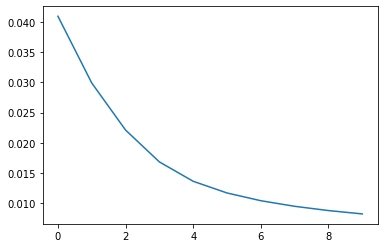

In [52]:
plt.plot(np.arange(0, num_epochs, 1), mean_epoch_error_list)

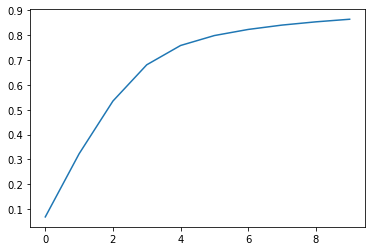

In [53]:
plt.plot(np.arange(0, num_epochs, 1), mean_epoch_train_accuracy_list)

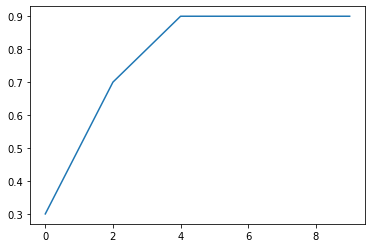

In [54]:
plt.plot(np.arange(0, num_epochs, 1), mean_epoch_test_accuracy_list)

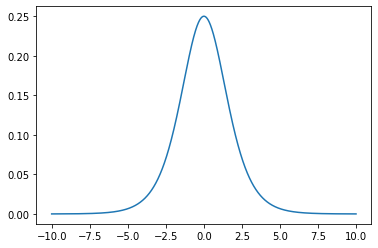

In [55]:
## check the sigmoid prime
X = np.arange(-10, 10, 0.01)
sp = list(map(lambda x: sigmoid_prime(x), X))
plt.plot(X, sp)